# Now we will create a custom Data Loader for our TinyVGG model

In [221]:
import os
import pathlib
import torch

from torch import nn
import random
from pathlib import Path
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision import models
from torchvision import datasets
import torchvision.utils

from typing import Tuple, Dict, List
from torch.utils.data import DataLoader


import aiml_utils.mytorch.utils as tu
import aiml_utils.data_import.wildflowersUtils as wfu

In [222]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [223]:
data_path = Path("../data/dataset")

# Setup train and testing paths
train_dir = data_path / "train"
test_dir = data_path / "test"
val_dir = data_path / "val"

train_dir, test_dir, val_dir

(PosixPath('../data/dataset/train'),
 PosixPath('../data/dataset/test'),
 PosixPath('../data/dataset/val'))

## Create a custom dataset/dataloader

We will assume the dataset is already created with aiml_utils.data_import.wildflowersUtils
Image file structure should look like:  
dataset  
    |_train   
        |_class1  
        |   |_image1  
        |   |_image2  
        |_class2  
        |   |_image  
    ...  
    |_test  
        |_class1  
    ...  
    |_val  
        |_class1  
    ...  


In [224]:
# def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
#   """Finds the class folder names in a target directory."""
#   # 1. Get the class names by scanning the target directory
#   classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

#   # 2. Raise an error if class names could not be found
#   if not classes:
#     raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

#   # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
#   class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
#   return classes, class_to_idx

In [225]:
class MyJpgImageFolderLoader(Dataset):  #extends Dataset
  # Initialize
  def __init__(self, 
               targ_dir: str, 
               transform=None):

    # Get all of the image paths

    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    # self.classes, self.class_to_idx = find_classes(targ_dir)
    self.classes = sorted(entry.name for entry in os.scandir(targ_dir) if entry.is_dir())
    if not self.classes:
      raise FileNotFoundError(f"Couldn't find any classes in {targ_dir}... please check file structure.")
    self.class_to_idx = {class_name: i for i, class_name in enumerate(self.classes)}


  # Image loading function
  def load_image(self, index: int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # Need to Override __len__()
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)
  
  # Override __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X, y)
    else:
      return img, class_idx # return untransformed image and label
    


# Create a transform
Resuse the one from our previous model

In [226]:
my_transformer_1 = transforms.Compose([
    #Resize, as our model (TinyVGG) is going to take 64x64 images
    transforms.Resize(size=(64,64)),
    # can do other cool things  like flips, etc, but will wait
    transforms.RandomApply(transforms=[
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5), 
        transforms.RandomRotation(degrees=(-180,180)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5)], p=0.5),
    # finally, we can use this setup to transform the images into tensors
    transforms.ToTensor(),
    transforms.Normalize((0.3, 0.3, 0.3), (0.9, 0.9, 0.9))
])

my_transformer_0 = transforms.Compose([
    #Resize, as our model (TinyVGG) is going to take 64x64 images
    transforms.Resize(size=(64,64)),
    # can do other cool things  like flips, etc, but will wait
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5), 
    transforms.RandomRotation(degrees=(-180,180)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.1),
    # finally, we can use this setup to transform the images into tensors
    transforms.ToTensor(),
    transforms.Normalize((0.3, 0.3, 0.3), (0.5, 0.5, 0.5))
])


my_test_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

val_transformer = transforms.Compose([
    transforms.Resize(size=(64,64))
])

normalizer = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.2, 0.2, 0.2), (0.9, 0.9, 0.9))
    transforms.Normalize((0.35, 0.35, 0.35), (0.9, 0.9, 0.9))
    #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [227]:
# train_data = MyJpgImageFolderLoader(targ_dir=train_dir, transform=my_transformer_0)
# test_data = MyJpgImageFolderLoader(targ_dir=test_dir, transform=my_test_transform)

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=my_transformer_0,
                                  target_transform=None) # this is a transform for the labels - no need for it here... It is optional

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=my_transformer_0)

val_data = datasets.ImageFolder(root=val_dir,
                                 transform=my_test_transform)

In [228]:
normalized_images = datasets.ImageFolder(root=val_dir, transform=normalizer)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


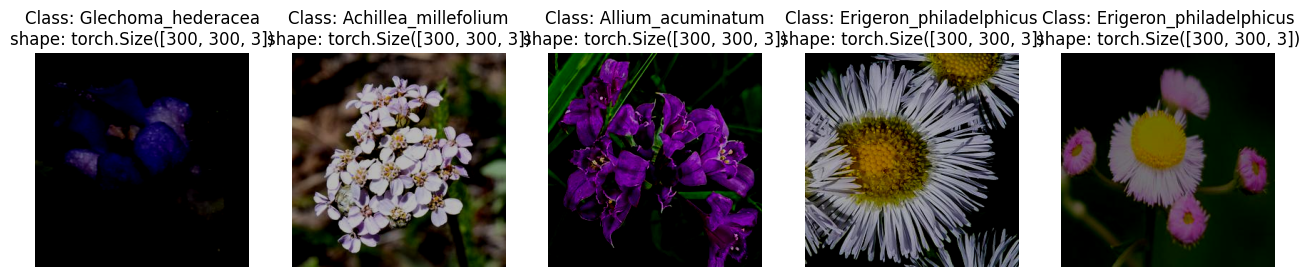

In [229]:
tu.display_random_images(dataset=normalized_images, classes=normalized_images.classes, n=5)

In [230]:
len(val_data)

844

In [231]:
len(train_data)

4059

In [232]:
# val_data.targets

In [233]:
# val_data.classes

In [234]:
# train_data.class_to_idx

In [235]:
class_names = train_data.classes
class_names, len(class_names)

(['Achillea_lanulosa',
  'Achillea_millefolium',
  'Aconitum_columbianum',
  'Agastache_urticafolia',
  'Agoseris_aurantiiaca',
  'Agoseris_glauca',
  'Allium_acuminatum',
  'Allium_cernuum',
  'Alpine Aster',
  'Alyssum_simplex',
  'Amelanchier_alnifolia',
  'Androsace_septentrionalis',
  'Angelica_ampla',
  'Angelica_grayi',
  'Antennaria_corymbosa',
  'Antennaria_parvifolia',
  'Antennaria_rosea',
  'Anticlea_elegans',
  'Aquilegia_chrysantha',
  'Aquilegia_coerulea',
  'Aquilegia_elegantula',
  'Arnica_cordifolia',
  'Arnica_mollis',
  'Arnica_parryi',
  'Arrowleaf Senecio',
  'Artemisia_dracunculus',
  'Asclepias_speciosa',
  'Erigeron_philadelphicus',
  'Glechoma_hederacea',
  'Lupinus_argenteus',
  'Prunella_vulgaris'],
 31)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


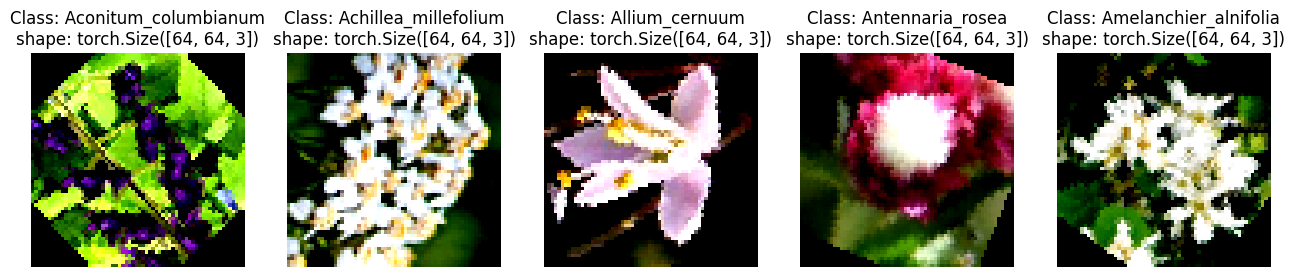

In [236]:
tu.display_random_images(dataset=train_data, classes=train_data.classes, n=5)

Cool.  Lets see if it works in a model.  

In [237]:
BATCH_SIZE = 32#200#32
NUM_WORKERS = os.cpu_count()-2
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
val_dataloader = DataLoader(dataset=val_data, batch_size=BATCH_SIZE, num_workers=1, shuffle=False)

In [238]:
# Here's another way to look at images from the dataset using the dataloader!
# import numpy as np
# def imshow(inp, title=None):
#     """Display image for Tensor."""
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  

# # Get a batch of training data
# inputs, classes = next(iter(train_dataloader))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

# Create the Model.  Let's use Resnet50 from pytorch for model 1

In [283]:
# from torchvision.models import vgg16, VGG16_Weights - VGG just doesn't perform well here

# model_1 = vgg16(weights=VGG16_Weights, progress=True)
# #model_1 = vgg16()
 
from torchvision.models import resnet50, ResNet50_Weights

model_1 = resnet50(ResNet50_Weights).to(device)



/home/candrews/anaconda3/envs/cuml/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/candrews/anaconda3/envs/cuml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [284]:
model_1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [285]:
# Freeze all of the base layers 
# Note: this does not seem to improve the model significantly and may make it worse for this application
for param in model_1.parameters():
  # print(param)
  param.requires_grad = False

In [287]:
num_inputs = model_1.fc.in_features
#model_1.fc = nn.Linear(num_inputs, len(train_data.classes))

model_1.fc = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=num_inputs, # feature vector coming in
              out_features=len(train_data.classes))).to(device) # how many classes do we have?

In [288]:
model_1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [289]:
# see if the dataloader works
image_batch, label_batch = next(iter(train_dataloader))
image_batch.shape


torch.Size([32, 3, 64, 64])

In [290]:
model_1.to(device)
model_1(image_batch.to(device))

tensor([[ 9.8894e-02, -2.5614e-01,  6.2379e-01,  2.4385e-01,  1.7876e-01,
         -4.9769e-02, -5.2412e-01,  2.5017e-01,  6.8672e-02, -2.9813e-01,
          5.6298e-01,  2.3031e-01,  2.6724e-01,  2.6918e-01,  5.0664e-01,
         -3.9789e-02, -1.5643e-01,  6.4891e-02, -1.8171e-01, -1.2841e-01,
         -1.0090e-01,  5.4969e-02,  1.7533e-01, -4.5037e-02, -8.9724e-02,
         -1.2930e-01,  6.4400e-02,  7.4901e-01, -4.2490e-01,  1.1461e-01,
         -4.9954e-01],
        [ 7.1403e-01, -1.4183e+00,  2.7685e-01, -6.9514e-03,  8.2391e-01,
          3.2297e-01, -6.0867e-01, -4.9198e-01,  9.9237e-01,  3.4233e-02,
          5.9464e-02,  1.6491e-01, -1.2426e-01,  2.0640e-02, -2.7389e-01,
          3.8104e-01,  3.1257e-01, -9.6673e-02, -2.1960e-01, -2.0208e-02,
          7.9458e-01, -8.4531e-02,  4.3059e-01,  1.5867e-01,  1.0443e-01,
          2.2889e-02,  7.0959e-01, -3.9456e-01,  1.6472e-01, -1.2778e-01,
         -4.1897e-01],
        [ 1.4141e-01, -5.6946e-02,  2.1730e-01,  1.7242e-01,  3.22

In [291]:
from torchinfo import summary
summary(model_1, input_size=[32, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 31]                  --
├─Conv2d: 1-1                            [32, 64, 32, 32]          (9,408)
├─BatchNorm2d: 1-2                       [32, 64, 32, 32]          (128)
├─ReLU: 1-3                              [32, 64, 32, 32]          --
├─MaxPool2d: 1-4                         [32, 64, 16, 16]          --
├─Sequential: 1-5                        [32, 256, 16, 16]         --
│    └─Bottleneck: 2-1                   [32, 256, 16, 16]         --
│    │    └─Conv2d: 3-1                  [32, 64, 16, 16]          (4,096)
│    │    └─BatchNorm2d: 3-2             [32, 64, 16, 16]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 16, 16]          --
│    │    └─Conv2d: 3-4                  [32, 64, 16, 16]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 16, 16]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 16, 16]   

In [294]:
from tqdm.auto import tqdm
from timeit import default_timer as timer
from torch.optim import lr_scheduler
# train_time_start = timer()

EPOCHS = 1000  # make this higher!

# Setup loss function and optimizer
loss_function = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Decay LR by a factor of gamma every step_size epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)

In [295]:
#Train for an epoch to eliminate any large loss values that will mess up my loss curve
tu.train(model=model_1, 
                   train_dataloader=train_dataloader, 
                   test_dataloader=test_dataloader, 
                   loss_fn=loss_function, 
                   optimizer=optimizer,
                   lr_scheduler=None,#exp_lr_scheduler,
                   epochs=1)

results = tu.train(model=model_1, 
                   train_dataloader=train_dataloader, 
                   test_dataloader=test_dataloader, 
                   loss_fn=loss_function, 
                   optimizer=optimizer,
                   lr_scheduler=exp_lr_scheduler,
                   epochs=200, save_best=True, save_file="ResNet50_Model_1.pth")

# train_time_end = timer() 
# total_train_time_model_0 = tu.print_train_time(start=train_time_start,
#                                             end=train_time_end,
#                                             device=str(next(model_1.parameters()).device))

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 4.3387 | Train acc: 0.6555 | Test loss: 3.4508 | Test acc: 0.7219


  0%|          | 0/200 [00:00<?, ?it/s]

adjusting learning rate to 0.001
Epoch: 0 | Train loss: 4.1268 | Train acc: 0.6577 | Test loss: 3.3378 | Test acc: 0.7189
adjusting learning rate to 0.001
Epoch: 1 | Train loss: 4.2282 | Train acc: 0.6656 | Test loss: 3.1039 | Test acc: 0.7292
adjusting learning rate to 0.001
Epoch: 2 | Train loss: 3.7745 | Train acc: 0.6681 | Test loss: 3.0804 | Test acc: 0.7300
adjusting learning rate to 0.001
Epoch: 3 | Train loss: 4.0620 | Train acc: 0.6654 | Test loss: 2.9185 | Test acc: 0.7203
adjusting learning rate to 0.001
Epoch: 4 | Train loss: 3.7492 | Train acc: 0.6723 | Test loss: 3.1649 | Test acc: 0.7300
adjusting learning rate to 0.001
Epoch: 5 | Train loss: 3.8659 | Train acc: 0.6679 | Test loss: 2.8772 | Test acc: 0.7502
adjusting learning rate to 0.001
Epoch: 6 | Train loss: 3.4340 | Train acc: 0.6883 | Test loss: 3.2116 | Test acc: 0.7473
adjusting learning rate to 0.001
Epoch: 7 | Train loss: 3.5970 | Train acc: 0.6741 | Test loss: 3.0653 | Test acc: 0.7443
adjusting learning rate 

In [296]:
results

{'train_loss': [4.126833792746536,
  4.228159548260096,
  3.7744615068585854,
  4.062003278356838,
  3.749241489125049,
  3.8659071471747453,
  3.43400993028025,
  3.596991473295557,
  3.2983056853606008,
  3.613887688775701,
  3.5204542725104986,
  3.3078127259344567,
  3.49997985503805,
  3.33368237351808,
  3.306710163674017,
  3.4148963483299797,
  3.370023654671166,
  3.390656154925429,
  3.147446005363164,
  3.1955390680493334,
  3.3458048227265125,
  3.3971504226444273,
  3.0616362479728036,
  3.144868876521043,
  3.2021706423421543,
  3.2782358982431608,
  3.0639580253541,
  3.0723148298075817,
  3.095486466340193,
  2.9854364104158297,
  3.0875970603912832,
  2.954873699841537,
  3.074212965064161,
  3.086293499300799,
  3.136843450895445,
  2.9869474289924143,
  2.933507753169443,
  2.870074756032839,
  2.994285366197271,
  2.7664956642886787,
  2.932956870381288,
  2.968410238506287,
  2.8712925429888596,
  2.933086766971378,
  2.8971021212930754,
  2.8309466890462742,
  2.8

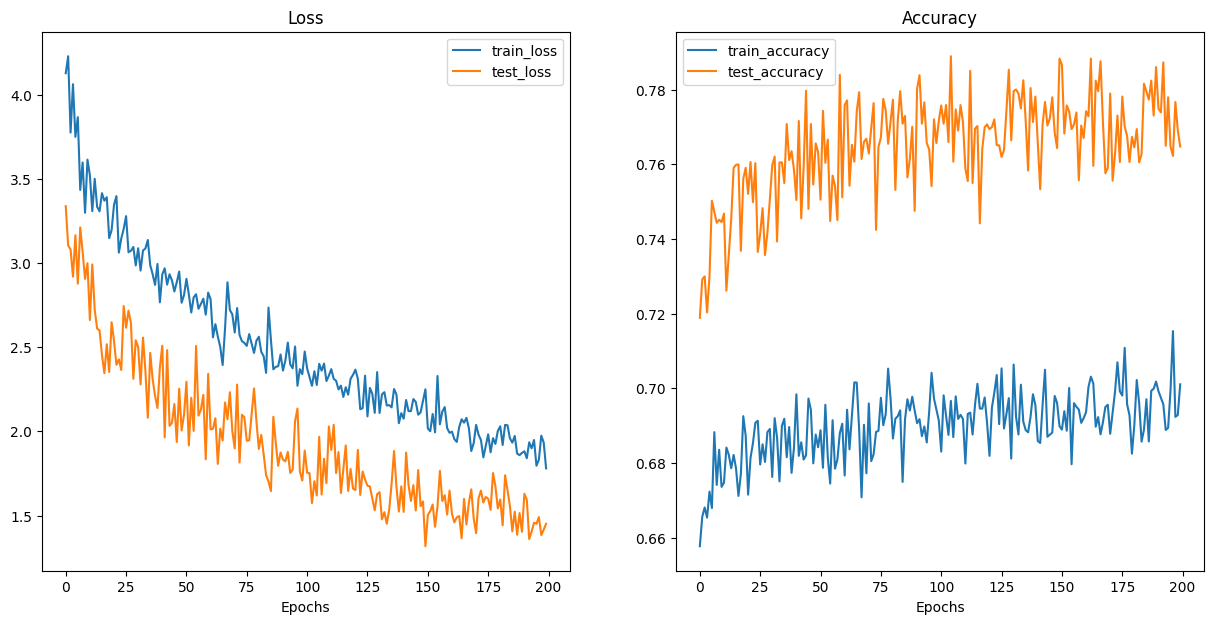

In [297]:
tu.plot_loss_curves(results)

In [283]:
class TinyVGG(nn.Module):
  """
  Model architecture copying TinyVGG from CNN Explainer: https://poloclub.github.io/cnn-explainer/
  """
  def __init__(self, 
               input_shape: int,
               hidden_units: int,
               output_shape: int) -> None:
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2) # default stride value is same as kernel_size
    )
    self.classifier = nn.Sequential(
        nn.Flatten(), 
        nn.Linear(in_features=hidden_units*13*13,#*72*72,#*69*69,#*26*26,#*29*29,#*13*13, #initially no 13 x 13
                  out_features=output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape) # running this will tell us what the size should be for the classifier 'in_features'
    x = self.classifier(x)
    #print(x.shape)
    return x
    # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operator fusion: https://horace.io/brrr_intro.html

In [284]:
class_names = train_data.classes

In [293]:
model_0 = TinyVGG(input_shape=3, # number of color channels in our image data
                  hidden_units=10, 
                  output_shape=len(class_names)).to(device)

In [294]:
from tqdm.auto import tqdm
from timeit import default_timer as timer
from torch.optim import lr_scheduler

# train_time_start = timer()

EPOCHS = 25  # make this higher!

# Setup loss function and optimizer
loss_function = nn.CrossEntropyLoss()
#optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.01)

# Decay LR by a factor of gamma every step_size epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.01)

In [295]:
optimizer.param_groups[0]['lr']
#len(optimizer.param_groups)

0.01

In [296]:
results_0 = tu.train(model=model_0, 
                   train_dataloader=train_dataloader, 
                   test_dataloader=test_dataloader, 
                   loss_fn=loss_function, 
                   optimizer=optimizer,
                   lr_scheduler=None,#exp_lr_scheduler,
                   epochs=EPOCHS )

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 1.3192 | Train acc: 0.4330 | Test loss: 0.9509 | Test acc: 0.6136
Epoch: 1 | Train loss: 0.9244 | Train acc: 0.6613 | Test loss: 0.8439 | Test acc: 0.6597
Epoch: 2 | Train loss: 0.8293 | Train acc: 0.6914 | Test loss: 0.7129 | Test acc: 0.7426
Epoch: 3 | Train loss: 0.7450 | Train acc: 0.7199 | Test loss: 0.8275 | Test acc: 0.7142
Epoch: 4 | Train loss: 0.8524 | Train acc: 0.7262 | Test loss: 0.7324 | Test acc: 0.7170
Epoch: 5 | Train loss: 0.7648 | Train acc: 0.7105 | Test loss: 0.6929 | Test acc: 0.7256
Epoch: 6 | Train loss: 0.6867 | Train acc: 0.7395 | Test loss: 0.6891 | Test acc: 0.7159
Epoch: 7 | Train loss: 0.6708 | Train acc: 0.7367 | Test loss: 1.0118 | Test acc: 0.6114
Epoch: 8 | Train loss: 0.7313 | Train acc: 0.7324 | Test loss: 0.7700 | Test acc: 0.7494
Epoch: 9 | Train loss: 0.6946 | Train acc: 0.7553 | Test loss: 0.7765 | Test acc: 0.7165
Epoch: 10 | Train loss: 0.6832 | Train acc: 0.7494 | Test loss: 0.6859 | Test acc: 0.7449
Epoch: 11 | Train lo

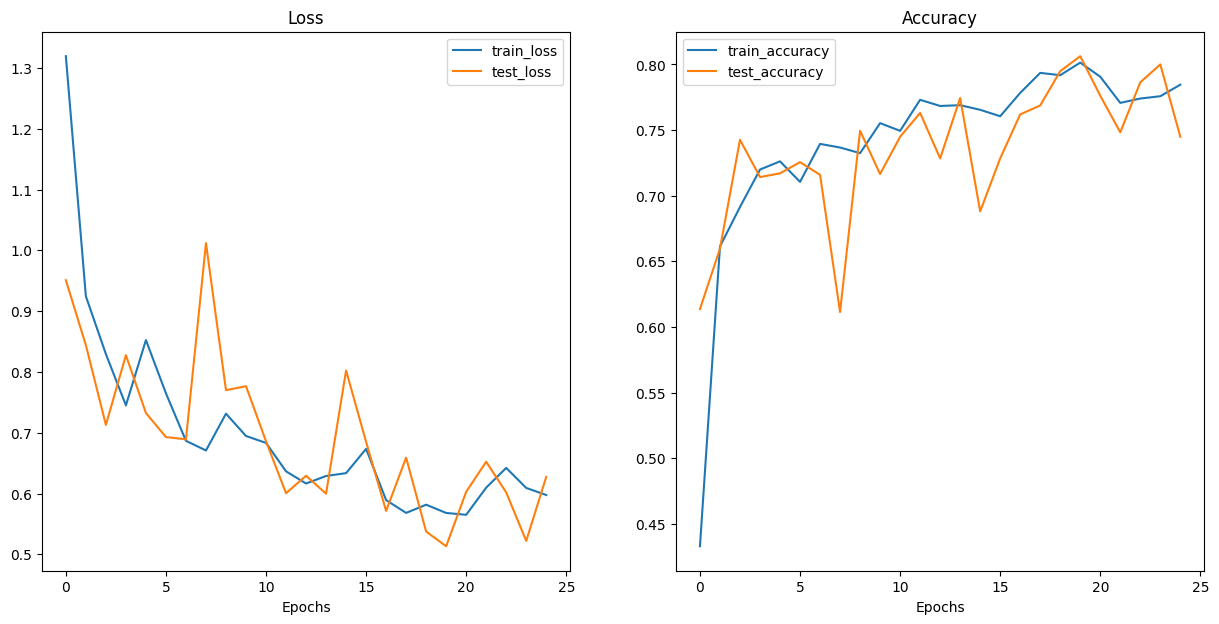

In [297]:
tu.plot_loss_curves(results_0)

# Check things out with a validation set image  

In [196]:
image_path_list = list(val_dir.glob("*.jpg")) # kaggle
image_path_list

[]

Image path: ../data/dataset/val/Achillea_millefolium/Achillea_millefolium231.jpg
Image class: Achillea_millefolium
Custom image shape: torch.Size([3, 300, 300])


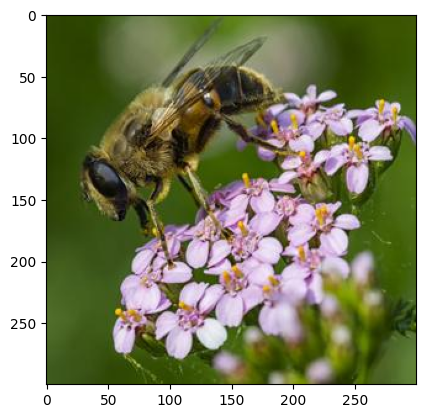

In [197]:
import torchvision

#val_image_path = val_dir / "04-pizza-dad.jpeg"

image_path_list = list(val_dir.glob("*/*.jpg")) # kaggle

val_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = val_image_path.parent.stem

# 4. Open image
#image = Image.open(val_image_path)
custom_image_uint8 = torchvision.io.read_image(str(val_image_path))

# 5. Print metadata 
print(f"Image path: {val_image_path}")
print(f"Image class: {image_class}")
#print(f"Image height: {custom_image_uint8.height}")
#print(f"Image width: {custom_image_uint8.width}")

print(f"Custom image shape: {custom_image_uint8.shape}")

plt.imshow(custom_image_uint8.permute(1, 2, 0));

### Need to transform our image before it can go into the model
Use plain old 'my_test_transform' which just resizes and turns it into a tensor

In [198]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(val_image_path)).type(torch.float32) / 255.

In [199]:
#hmmm.. maybe we dont need to convert to Tensor...
custom_image_transform = transforms.Compose([ transforms.Resize(size=(64, 64))])  

#transformed_val_image = my_test_transform(custom_image)
transformed_val_image = custom_image_transform(custom_image)

# Print out the shapes
print(f"Original shape: {custom_image.shape}")
#print(f"Transformed shape: {transformed_val_image.shape}")


Original shape: torch.Size([3, 300, 300])


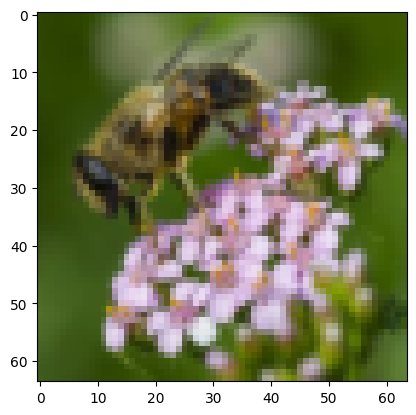

In [200]:
plt.imshow(transformed_val_image.permute(1, 2, 0))

In [201]:
# Need to add a batch size dimension (unsqueeze) and then send to the GPU
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(transformed_val_image.unsqueeze(0).to(device))
custom_image_pred

tensor([[-14.9726,   0.3498, -10.4425, -16.3605, -19.2824,  -2.5570,  -7.9927,
           3.9353, -30.1449, -12.8607,  -6.9385,   1.9074, -33.6687, -17.7355,
         -15.2151, -12.6660,  -4.9876, -13.5880, -30.4728,  -6.8375, -34.5769,
         -18.3288, -32.6370, -49.4411, -48.7638, -15.0538,  -9.0927, -14.0230,
          -9.3742,  -2.8492, -12.7718]], device='cuda:0')

In [202]:
# these are logits, need to convert to probabilities
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
custom_image_pred_probs

tensor([[5.2862e-09, 2.3854e-02, 4.9040e-07, 1.3194e-09, 7.1023e-11, 1.3036e-03,
         5.6817e-06, 8.6046e-01, 1.3611e-15, 4.3682e-08, 1.6304e-05, 1.1325e-01,
         4.0136e-17, 3.3358e-10, 4.1478e-09, 5.3075e-08, 1.1470e-04, 2.1108e-08,
         9.8056e-16, 1.8036e-05, 1.6185e-17, 1.8431e-10, 1.1261e-16, 5.6707e-24,
         1.1163e-23, 4.8739e-09, 1.8912e-06, 1.3663e-08, 1.4272e-06, 9.7337e-04,
         4.7746e-08]], device='cuda:0')

In [203]:
# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1).cpu()
custom_image_pred_label

tensor([7])

In [204]:
class_names

['Achillea_lanulosa',
 'Achillea_millefolium',
 'Aconitum_columbianum',
 'Agastache_urticafolia',
 'Agoseris_aurantiiaca',
 'Agoseris_glauca',
 'Allium_acuminatum',
 'Allium_cernuum',
 'Alpine Aster',
 'Alyssum_simplex',
 'Amelanchier_alnifolia',
 'Androsace_septentrionalis',
 'Angelica_ampla',
 'Angelica_grayi',
 'Antennaria_corymbosa',
 'Antennaria_parvifolia',
 'Antennaria_rosea',
 'Anticlea_elegans',
 'Aquilegia_chrysantha',
 'Aquilegia_coerulea',
 'Aquilegia_elegantula',
 'Arnica_cordifolia',
 'Arnica_mollis',
 'Arnica_parryi',
 'Arrowleaf Senecio',
 'Artemisia_dracunculus',
 'Asclepias_speciosa',
 'Erigeron_philadelphicus',
 'Glechoma_hederacea',
 'Lupinus_argenteus',
 'Prunella_vulgaris']

In [205]:
class_names[custom_image_pred_label]

'Allium_cernuum'

There is no specific classification layer for the Resnet model (no transfer learning involved) but we got good results... hmmm..

This is because we actually performed "fine-tuning" of the original model, this is perfectly legitimate, but usually using a large dataset and small learning rate.
Regardless, I went back in and did "transfer learning", where I froze the weights (except for the last classification block)

# A new Visualization method for Predictions

In [250]:
from aiml_utils.mytorch import pred_and_plot_image

#pred_and_plot_image(model=model_1, val)


def pred_random_val_image(model, dataset, device=device, num_images=1):
    '''Predict on a random image from the validation dataset'''

    img_count = 0
    model.to(device)
    model.eval()
    
    dataloader = DataLoader(dataset=dataset,batch_size=num_images, shuffle=True)

    images,targets = next(iter(dataloader))
    images = images.to(device)
    
    with torch.inference_mode():
        pred_logits = model(images)
        class_ints = pred_logits.argmax(dim=1)

    class_names = dataset.classes

    fig, axes = plt.subplots( num_images, 1, figsize=(5,5*num_images))
    #plt.figure(figsize=(7, 7*num_images))

    for i in range(num_images):
        image = images[i].cpu().numpy().transpose((1, 2, 0))
        label = str(f"Predicted: {class_names[class_ints[i]]} Actual: {class_names[targets[i]]}" )
        if class_ints[i] != targets[i]:
            color = "red"
        else:
            color = "black"
        if num_images == 1:  # this seems fundamentally wrong
            axes.imshow(image)
            axes.set_title(label, color=color)
            axes.axis('off')
        else:
            axes[i].imshow(image)
            axes[i].set_title(label, color=color)
            axes[i].axis('off')
    
    plt.show()



In [251]:
class_names

['Achillea_lanulosa',
 'Achillea_millefolium',
 'Aconitum_columbianum',
 'Agastache_urticafolia',
 'Agoseris_aurantiiaca',
 'Agoseris_glauca',
 'Allium_acuminatum',
 'Allium_cernuum',
 'Alpine Aster',
 'Alyssum_simplex',
 'Amelanchier_alnifolia',
 'Androsace_septentrionalis',
 'Angelica_ampla',
 'Angelica_grayi',
 'Antennaria_corymbosa',
 'Antennaria_parvifolia',
 'Antennaria_rosea',
 'Anticlea_elegans',
 'Aquilegia_chrysantha',
 'Aquilegia_coerulea',
 'Aquilegia_elegantula',
 'Arnica_cordifolia',
 'Arnica_mollis',
 'Arnica_parryi',
 'Arrowleaf Senecio',
 'Artemisia_dracunculus',
 'Asclepias_speciosa',
 'Erigeron_philadelphicus',
 'Glechoma_hederacea',
 'Lupinus_argenteus',
 'Prunella_vulgaris']

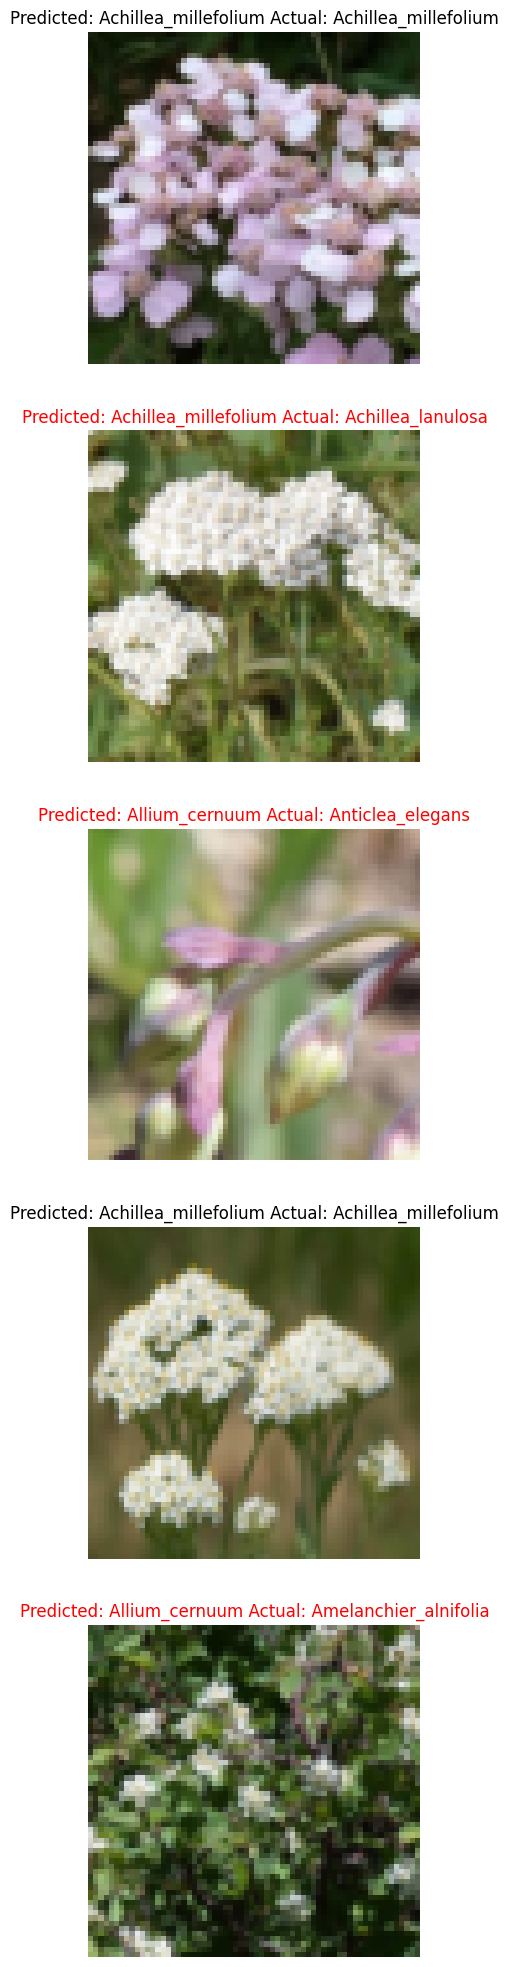

In [264]:
pred_random_val_image(model=model_1,
                      dataset=val_data,
                      device=device, 
                      num_images=5)

# Confusion Matrix

In [254]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

def plot_confusion_matrix_from_model(model, dataset, device=device, batch_size=32):
    '''Plot a confusion matrix for the model'''
    model.to(device)
    model.eval()

    class_names = dataset.classes

    y_true = []
    y_pred = []

    dataloader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    with torch.inference_mode():
        for images, targets in dataloader:
            images = images.to(device)
            targets = targets.to(device)
            
            pred_logits = model(images)
            #_,class_ints = torch.max(pred_logits,1)#pred_logits.argmax(dim=1)
            class_ints = pred_logits.argmax(dim=1)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(class_ints.cpu().numpy())

    # 2. Setup confusion instance and compare predictions to targets
    #print(len(class_names))
    confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
    confmat_tensor = confmat(preds=torch.tensor(y_pred), target=torch.tensor(y_true))
    y_true = torch.tensor(y_true)
    y_pred = torch.tensor(y_pred)
    print("y_true shape:", y_true.shape)
    print("y_pred shape:", y_pred.shape)
    print("num classses:", len(class_names))
    #3. Plot the confusion matrix
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(), # matplotlib likes working with numpy
        class_names=class_names,
        figsize=(10, 10)
    )

In [255]:
targets = torch.tensor(val_data.targets)
targets.shape

torch.Size([844])

# Reload our best weights

In [258]:
# reload our best model params
MODEL_NAME = "../models/ResNet50_Model_1.pth"

model1_best = resnet50()
num_inputs = model1_best.fc.in_features
model1_best.fc = nn.Linear(num_inputs, len(train_data.classes))
model1_best.load_state_dict(torch.load("../models/ResNet50_Model_1.pth")['model_state_dict'])

<All keys matched successfully>

y_true shape: torch.Size([1359])
y_pred shape: torch.Size([1359])
num classses: 31


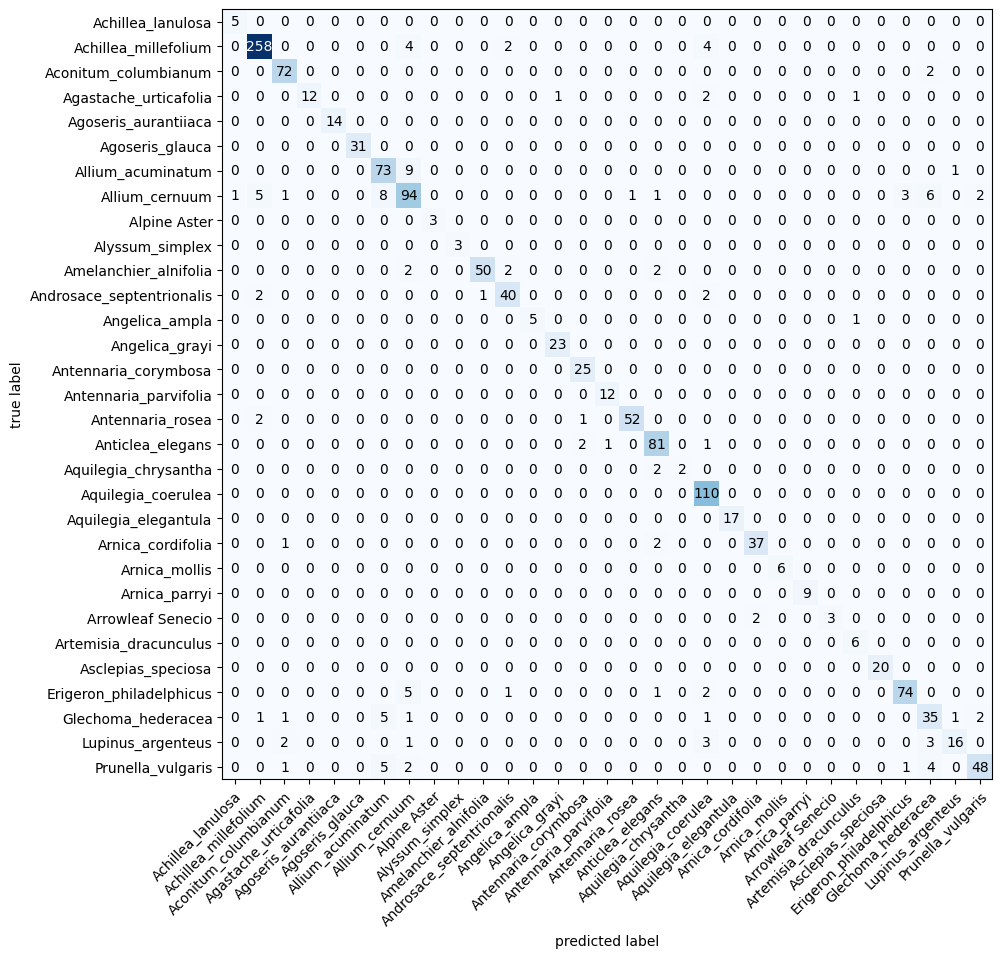

In [262]:
plot_confusion_matrix_from_model(model1_best, test_data)

Obviously not a well balanced dataset, we need more examples from many classes

In [256]:
# Chat GPT version!
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

def chatGPT_plot_confusion_matrix(model, dataloader, classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


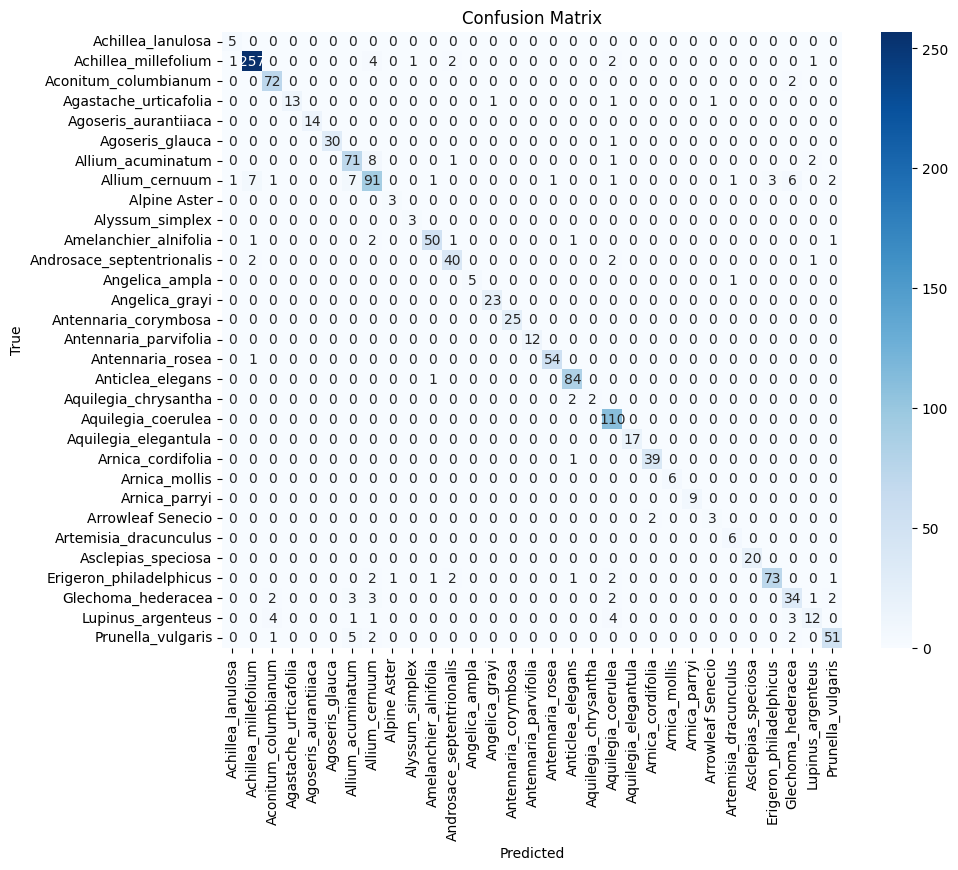

In [261]:
chatGPT_plot_confusion_matrix(model1_best, test_dataloader, test_data.classes)

OMG!  it worked!, though oddly not quite the same values

# New model

In [269]:
# model_2 = resnet50(pretrained=True)
# num_classes = len(train_data.classes)


/home/candrews/anaconda3/envs/cuml/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/candrews/anaconda3/envs/cuml/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
